#**DETEKSI DEPRESI** 

In [ ]:
!pip install swifter
!pip install sastrawi
!pip install tweet-preprocessor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 647 kB 8.8 MB/s 
     |████████████████████████████████| 281 kB 47.9 MB/s 
     |████████████████████████████████| 140 kB 64.8 MB/s 
  Created wheel for swifter: filename=swifter-1.1.3-py3-none-any.whl size=13078 sha256=6126be9b6e22dac244c08138f0313d122734c1e9ebad70697ecc6212e0d79ecd
  Stored in directory: /root/.cache/pip/wheels/e8/1a/1b/46aa7b0fac16d3ce1bccaac14bfe4fad972642217ae78d8160
Successfully built swifter
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 7.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Libraries
import pandas as pd
import numpy as np
import swifter
import seaborn as sns
import matplotlib.pyplot as plt

# Regex Library
import re

# Preprocessor Library
import preprocessor as pre

# NLTK Libraries
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer

# Sastrawi Library
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Sckit Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df = pd.read_csv ('raw_data.csv',encoding="ISO-8859-1")

In [ ]:
df.head()

,Username,User,Tweet,Label
0,taekucheng,User 1,@orreoredvelvet Sedih bet yhð¥² Tp sedih juga...,1
1,ekaagung52,User 2,@15eights @sbmptnfess haloo maaf banget akunny...,1
2,_shahahahahaha,User 3,"@polbanfess Ya beda-beda atuh, ga bisa disamar...",1
3,zephaniaky,User 4,"@i0heum Kenapahhh, @i0heum kamu selonya kapan ...",1
4,arranjj,User 5,"@purpleasehere @wafdaishere bener bestie, mung...",1


In [ ]:
df = df.drop(columns=['Username'])
df.head()

,User,Tweet,Label
0,User 1,@orreoredvelvet Sedih bet yhð¥² Tp sedih juga...,1
1,User 2,@15eights @sbmptnfess haloo maaf banget akunny...,1
2,User 3,"@polbanfess Ya beda-beda atuh, ga bisa disamar...",1
3,User 4,"@i0heum Kenapahhh, @i0heum kamu selonya kapan ...",1
4,User 5,"@purpleasehere @wafdaishere bener bestie, mung...",1


## **DATA EXPLORATORY**

In [ ]:
len(df)

157

In [ ]:
# Mengecek jumlah masing-masing label
df['Label'].value_counts()

1    92
0    65
Name: Label, dtype: int64

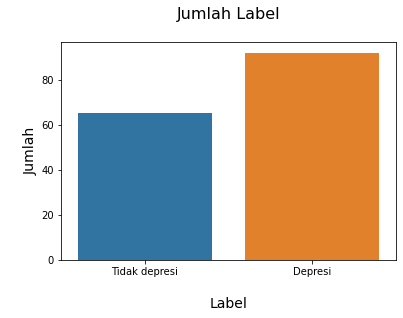

In [ ]:
# Memvisualisasi jumlah label pada kolom 'Label' 
df_label = sns.countplot(df['Label'])
df_label.set_xticklabels(['Tidak depresi','Depresi'])
plt.xlabel('\nLabel', size = 14)
plt.ylabel('\nJumlah', size = 14)
plt.title('Jumlah Label\n', size = 16)
plt.show()

## **PREPROCESSING**

### Case Folding

Mengubah seluruh kata menjadi huruf kecil

In [ ]:
# Case Folding
df['After Case Folding']= df['Tweet'].str.lower()
df = df[['Tweet', 'After Case Folding', 'Label']]
df.head(10)

,Tweet,After Case Folding,Label
0,@orreoredvelvet Sedih bet yhð¥² Tp sedih juga...,@orreoredvelvet sedih bet yhð¥² tp sedih juga...,1
1,@15eights @sbmptnfess haloo maaf banget akunny...,@15eights @sbmptnfess haloo maaf banget akunny...,1
2,"@polbanfess Ya beda-beda atuh, ga bisa disamar...","@polbanfess ya beda-beda atuh, ga bisa disamar...",1
3,"@i0heum Kenapahhh, @i0heum kamu selonya kapan ...","@i0heum kenapahhh, @i0heum kamu selonya kapan ...",1
4,"@purpleasehere @wafdaishere bener bestie, mung...","@purpleasehere @wafdaishere bener bestie, mung...",1
5,@Noviafbr__ Beda sama akumah :)) @khilda207 Ce...,@noviafbr__ beda sama akumah :)) @khilda207 ce...,0
6,Mood bangetð¤£ð¤£ð¤£ Apa sih kok jadi demen...,mood bangetð¤£ð¤£ð¤£ apa sih kok jadi demen...,0
7,seremmmm @hyunjaeism minta ajarin tetehhhh @hy...,seremmmm @hyunjaeism minta ajarin tetehhhh @hy...,0
8,@telyufess Org sukabumi pada tilil gini kenapa...,@telyufess org sukabumi pada tilil gini kenapa...,1
9,Respect sangat dengan lingkungan spt ini @tely...,respect sangat dengan lingkungan spt ini @tely...,0


### Data Cleaning

Membersihkan data dari angka, tanda baca, dan emotikon.

In [ ]:
# Fungsi Noise removal
def normalization(text):
    tweet = str(text)
    pre.set_options(pre.OPT.EMOJI, pre.OPT.HASHTAG, pre.OPT.MENTION, pre.OPT.NUMBER, pre.OPT.SMILEY, pre.OPT.URL)
    tweet = pre.clean(text)
    return tweet

In [ ]:
import string
string.punctuation

# Fungsi Remove Punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

def remove(text):
  hapus="".join([i for i in text if i not in string.punctuation])
  return hapus

In [ ]:
# Fungsi menghapus karakter single
def remove_single(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

In [ ]:
# Fungsi menghapus angka
def remove_number(text):
  return  re.sub(r"\d+", "", text)

In [ ]:
# Fungsi menghapus whitespace
def remove_whitespace(text):
    return text.strip()

In [ ]:
# Fungsi menghapus multiple whitespace
def remove_multiple(text):
    return re.sub('\s+',' ',text) 

In [ ]:
# Apply semua fungsi
df['After Cleaning'] = df['After Case Folding'].apply(normalization)
df['After Cleaning'] = df['After Cleaning'].apply(remove_punctuation)
df['After Cleaning'] = df['After Cleaning'].apply(remove)
df['After Cleaning'] = df['After Cleaning'].apply(remove_single)
df['After Cleaning'] = df['After Cleaning'].apply(remove_number)
df['After Cleaning'] = df['After Cleaning'].apply(remove_whitespace)
df['After Cleaning'] = df['After Cleaning'].apply(remove_multiple)
df = df[['Tweet', 'After Case Folding', 'After Cleaning', 'Label']]
df.head(10)

,Tweet,After Case Folding,After Cleaning,Label
0,@orreoredvelvet Sedih bet yhð¥² Tp sedih juga...,@orreoredvelvet sedih bet yhð¥² tp sedih juga...,sedih bet yh tp sedih juga ya soalnya halapeny...,1
1,@15eights @sbmptnfess haloo maaf banget akunny...,@15eights @sbmptnfess haloo maaf banget akunny...,haloo maaf banget akunnya udah ada yang ambil ...,1
2,"@polbanfess Ya beda-beda atuh, ga bisa disamar...","@polbanfess ya beda-beda atuh, ga bisa disamar...",ya bedabeda atuh ga bisa disamaratakan coba mi...,1
3,"@i0heum Kenapahhh, @i0heum kamu selonya kapan ...","@i0heum kenapahhh, @i0heum kamu selonya kapan ...",kenapahhh kamu selonya kapan aja gatau sabtu s...,1
4,"@purpleasehere @wafdaishere bener bestie, mung...","@purpleasehere @wafdaishere bener bestie, mung...",bener bestie mungkin nanti bisa di upgrade jd ...,1
5,@Noviafbr__ Beda sama akumah :)) @khilda207 Ce...,@noviafbr__ beda sama akumah :)) @khilda207 ce...,beda sama akumah cengos da siamah ath wkwk hah...,0
6,Mood bangetð¤£ð¤£ð¤£ Apa sih kok jadi demen...,mood bangetð¤£ð¤£ð¤£ apa sih kok jadi demen...,mood banget apa sih kok jadi demen ngomong kam...,0
7,seremmmm @hyunjaeism minta ajarin tetehhhh @hy...,seremmmm @hyunjaeism minta ajarin tetehhhh @hy...,seremmmm minta ajarin tetehhhh oceee thanks ji...,0
8,@telyufess Org sukabumi pada tilil gini kenapa...,@telyufess org sukabumi pada tilil gini kenapa...,org sukabumi pada tilil gini kenapa ya coba mn...,1
9,Respect sangat dengan lingkungan spt ini @tely...,respect sangat dengan lingkungan spt ini @tely...,respect sangat dengan lingkungan spt ini bisa ...,0


### Tokenization

In [ ]:
# Tokenizing
def tokenize(text):
    return word_tokenize(text)

In [ ]:
df['After Tokenize'] = df['After Cleaning'].apply(tokenize)
df = df[['Tweet', 'After Case Folding', 'After Cleaning', 'After Tokenize', 'Label']]
df.head(10)

,Tweet,After Case Folding,After Cleaning,After Tokenize,Label
0,@orreoredvelvet Sedih bet yhð¥² Tp sedih juga...,@orreoredvelvet sedih bet yhð¥² tp sedih juga...,sedih bet yh tp sedih juga ya soalnya halapeny...,"[sedih, bet, yh, tp, sedih, juga, ya, soalnya,...",1
1,@15eights @sbmptnfess haloo maaf banget akunny...,@15eights @sbmptnfess haloo maaf banget akunny...,haloo maaf banget akunnya udah ada yang ambil ...,"[haloo, maaf, banget, akunnya, udah, ada, yang...",1
2,"@polbanfess Ya beda-beda atuh, ga bisa disamar...","@polbanfess ya beda-beda atuh, ga bisa disamar...",ya bedabeda atuh ga bisa disamaratakan coba mi...,"[ya, bedabeda, atuh, ga, bisa, disamaratakan, ...",1
3,"@i0heum Kenapahhh, @i0heum kamu selonya kapan ...","@i0heum kenapahhh, @i0heum kamu selonya kapan ...",kenapahhh kamu selonya kapan aja gatau sabtu s...,"[kenapahhh, kamu, selonya, kapan, aja, gatau, ...",1
4,"@purpleasehere @wafdaishere bener bestie, mung...","@purpleasehere @wafdaishere bener bestie, mung...",bener bestie mungkin nanti bisa di upgrade jd ...,"[bener, bestie, mungkin, nanti, bisa, di, upgr...",1
5,@Noviafbr__ Beda sama akumah :)) @khilda207 Ce...,@noviafbr__ beda sama akumah :)) @khilda207 ce...,beda sama akumah cengos da siamah ath wkwk hah...,"[beda, sama, akumah, cengos, da, siamah, ath, ...",0
6,Mood bangetð¤£ð¤£ð¤£ Apa sih kok jadi demen...,mood bangetð¤£ð¤£ð¤£ apa sih kok jadi demen...,mood banget apa sih kok jadi demen ngomong kam...,"[mood, banget, apa, sih, kok, jadi, demen, ngo...",0
7,seremmmm @hyunjaeism minta ajarin tetehhhh @hy...,seremmmm @hyunjaeism minta ajarin tetehhhh @hy...,seremmmm minta ajarin tetehhhh oceee thanks ji...,"[seremmmm, minta, ajarin, tetehhhh, oceee, tha...",0
8,@telyufess Org sukabumi pada tilil gini kenapa...,@telyufess org sukabumi pada tilil gini kenapa...,org sukabumi pada tilil gini kenapa ya coba mn...,"[org, sukabumi, pada, tilil, gini, kenapa, ya,...",1
9,Respect sangat dengan lingkungan spt ini @tely...,respect sangat dengan lingkungan spt ini @tely...,respect sangat dengan lingkungan spt ini bisa ...,"[respect, sangat, dengan, lingkungan, spt, ini...",0


### Stop Word Removal

Sebelum stop word akan mengubah kata-kata slang

In [ ]:
slang = pd.read_csv("slang.csv",encoding="ISO-8859-1")

In [ ]:
slang_dict = {}
for index, row in slang.iterrows():
    if row[0] not in slang:
        slang_dict[row[0]] = row[1]

In [ ]:
def removeslang(text):
    return [slang_dict[word] if word in slang_dict else word for word in text]

In [ ]:
df['After Remove Slang'] = df['After Tokenize'].apply(removeslang)
df = df[['Tweet', 'After Case Folding', 'After Cleaning','After Tokenize', 'After Remove Slang', 'Label']]
df.head(10)

,Tweet,After Case Folding,After Cleaning,After Tokenize,After Remove Slang,Label
0,@orreoredvelvet Sedih bet yhð¥² Tp sedih juga...,@orreoredvelvet sedih bet yhð¥² tp sedih juga...,sedih bet yh tp sedih juga ya soalnya halapeny...,"[sedih, bet, yh, tp, sedih, juga, ya, soalnya,...","[sedih, banget, ya, tetapi, sedih, juga, ya, s...",1
1,@15eights @sbmptnfess haloo maaf banget akunny...,@15eights @sbmptnfess haloo maaf banget akunny...,haloo maaf banget akunnya udah ada yang ambil ...,"[haloo, maaf, banget, akunnya, udah, ada, yang...","[haloo, maaf, banget, akunnya, sudah, ada, yan...",1
2,"@polbanfess Ya beda-beda atuh, ga bisa disamar...","@polbanfess ya beda-beda atuh, ga bisa disamar...",ya bedabeda atuh ga bisa disamaratakan coba mi...,"[ya, bedabeda, atuh, ga, bisa, disamaratakan, ...","[ya, beda beda, atuh, tidak, bisa, sama rataka...",1
3,"@i0heum Kenapahhh, @i0heum kamu selonya kapan ...","@i0heum kenapahhh, @i0heum kamu selonya kapan ...",kenapahhh kamu selonya kapan aja gatau sabtu s...,"[kenapahhh, kamu, selonya, kapan, aja, gatau, ...","[kenapahhh, kamu, selonya, kapan, saja, tak ta...",1
4,"@purpleasehere @wafdaishere bener bestie, mung...","@purpleasehere @wafdaishere bener bestie, mung...",bener bestie mungkin nanti bisa di upgrade jd ...,"[bener, bestie, mungkin, nanti, bisa, di, upgr...","[benar, bestie, mungkin, nanti, bisa, di, peni...",1
5,@Noviafbr__ Beda sama akumah :)) @khilda207 Ce...,@noviafbr__ beda sama akumah :)) @khilda207 ce...,beda sama akumah cengos da siamah ath wkwk hah...,"[beda, sama, akumah, cengos, da, siamah, ath, ...","[beda, sama, aku sih, cengos, dan, siamah, ath...",0
6,Mood bangetð¤£ð¤£ð¤£ Apa sih kok jadi demen...,mood bangetð¤£ð¤£ð¤£ apa sih kok jadi demen...,mood banget apa sih kok jadi demen ngomong kam...,"[mood, banget, apa, sih, kok, jadi, demen, ngo...","[suasana hati, banget, apa, sih, kok, jadi, su...",0
7,seremmmm @hyunjaeism minta ajarin tetehhhh @hy...,seremmmm @hyunjaeism minta ajarin tetehhhh @hy...,seremmmm minta ajarin tetehhhh oceee thanks ji...,"[seremmmm, minta, ajarin, tetehhhh, oceee, tha...","[seremmmm, meminta, ajarkan, tetehhhh, oceee, ...",0
8,@telyufess Org sukabumi pada tilil gini kenapa...,@telyufess org sukabumi pada tilil gini kenapa...,org sukabumi pada tilil gini kenapa ya coba mn...,"[org, sukabumi, pada, tilil, gini, kenapa, ya,...","[orang, sukabumi, pada, tilil, begini, kenapa,...",1
9,Respect sangat dengan lingkungan spt ini @tely...,respect sangat dengan lingkungan spt ini @tely...,respect sangat dengan lingkungan spt ini bisa ...,"[respect, sangat, dengan, lingkungan, spt, ini...","[respect, sangat, dengan, lingkungan, surat pe...",0


In [ ]:
# Remove stopwords
stop = stopwords.words("indonesian")
stop2 = pd.read_csv("stopword.csv")
list_stopwords = stop2["stopword"].tolist()
stop.extend(list_stopwords)

In [ ]:
def remove_stopwords(text):
    new_words = []
    for word in text:
        if word not in stop:
            new_words.append(word)
    return new_words

In [ ]:
df['After Stop Words'] = df['After Remove Slang'].apply(remove_stopwords)
df = df[['Tweet', 'After Case Folding', 'After Cleaning','After Tokenize', 'After Remove Slang', 'After Stop Words', 'Label']]
df.head(10)

,Tweet,After Case Folding,After Cleaning,After Tokenize,After Remove Slang,After Stop Words,Label
0,@orreoredvelvet Sedih bet yhð¥² Tp sedih juga...,@orreoredvelvet sedih bet yhð¥² tp sedih juga...,sedih bet yh tp sedih juga ya soalnya halapeny...,"[sedih, bet, yh, tp, sedih, juga, ya, soalnya,...","[sedih, banget, ya, tetapi, sedih, juga, ya, s...","[sedih, sedih, halapenyo, indah, lagunya, ming...",1
1,@15eights @sbmptnfess haloo maaf banget akunny...,@15eights @sbmptnfess haloo maaf banget akunny...,haloo maaf banget akunnya udah ada yang ambil ...,"[haloo, maaf, banget, akunnya, udah, ada, yang...","[haloo, maaf, banget, akunnya, sudah, ada, yan...","[maaf, akunnya, ambil, pengirimnya, ambil, web...",1
2,"@polbanfess Ya beda-beda atuh, ga bisa disamar...","@polbanfess ya beda-beda atuh, ga bisa disamar...",ya bedabeda atuh ga bisa disamaratakan coba mi...,"[ya, bedabeda, atuh, ga, bisa, disamaratakan, ...","[ya, beda beda, atuh, tidak, bisa, sama rataka...","[beda beda, sama ratakan, coba, daftar, angkat...",1
3,"@i0heum Kenapahhh, @i0heum kamu selonya kapan ...","@i0heum kenapahhh, @i0heum kamu selonya kapan ...",kenapahhh kamu selonya kapan aja gatau sabtu s...,"[kenapahhh, kamu, selonya, kapan, aja, gatau, ...","[kenapahhh, kamu, selonya, kapan, saja, tak ta...","[kenapahhh, selonya, tak tau, sabtu, selo, bes...",1
4,"@purpleasehere @wafdaishere bener bestie, mung...","@purpleasehere @wafdaishere bener bestie, mung...",bener bestie mungkin nanti bisa di upgrade jd ...,"[bener, bestie, mungkin, nanti, bisa, di, upgr...","[benar, bestie, mungkin, nanti, bisa, di, peni...","[bestie, peningkatan, bestie, peningkatan, tak...",1
5,@Noviafbr__ Beda sama akumah :)) @khilda207 Ce...,@noviafbr__ beda sama akumah :)) @khilda207 ce...,beda sama akumah cengos da siamah ath wkwk hah...,"[beda, sama, akumah, cengos, da, siamah, ath, ...","[beda, sama, aku sih, cengos, dan, siamah, ath...","[beda, aku sih, siamah, menutup, mun, kamojang...",0
6,Mood bangetð¤£ð¤£ð¤£ Apa sih kok jadi demen...,mood bangetð¤£ð¤£ð¤£ apa sih kok jadi demen...,mood banget apa sih kok jadi demen ngomong kam...,"[mood, banget, apa, sih, kok, jadi, demen, ngo...","[suasana hati, banget, apa, sih, kok, jadi, su...","[suasana hati, suka, berbicara, kamsudnya, sat...",0
7,seremmmm @hyunjaeism minta ajarin tetehhhh @hy...,seremmmm @hyunjaeism minta ajarin tetehhhh @hy...,seremmmm minta ajarin tetehhhh oceee thanks ji...,"[seremmmm, minta, ajarin, tetehhhh, oceee, tha...","[seremmmm, meminta, ajarkan, tetehhhh, oceee, ...","[seremmmm, ajarkan, tetehhhh, oceee, terima ka...",0
8,@telyufess Org sukabumi pada tilil gini kenapa...,@telyufess org sukabumi pada tilil gini kenapa...,org sukabumi pada tilil gini kenapa ya coba mn...,"[org, sukabumi, pada, tilil, gini, kenapa, ya,...","[orang, sukabumi, pada, tilil, begini, kenapa,...","[orang, sukabumi, tilil, coba, memanah, nyermi...",1
9,Respect sangat dengan lingkungan spt ini @tely...,respect sangat dengan lingkungan spt ini @tely...,respect sangat dengan lingkungan spt ini bisa ...,"[respect, sangat, dengan, lingkungan, spt, ini...","[respect, sangat, dengan, lingkungan, surat pe...","[respect, lingkungan, surat pemberitahuan tahu...",0


Setelah itu dilakukan proses untokenize dan tokenize kembali untuk memisahkan kata-kata yang menyatu.

In [ ]:
# Untokenizing
df['After Untokenize'] = df['After Stop Words'].apply(lambda x: TreebankWordDetokenizer().detokenize(x))
df = df[['Tweet', 'After Case Folding', 'After Cleaning','After Tokenize', 'After Remove Slang', 'After Stop Words', 'After Untokenize', 'Label']]
df.head(10)

,Tweet,After Case Folding,After Cleaning,After Tokenize,After Remove Slang,After Stop Words,After Untokenize,Label
0,@orreoredvelvet Sedih bet yhð¥² Tp sedih juga...,@orreoredvelvet sedih bet yhð¥² tp sedih juga...,sedih bet yh tp sedih juga ya soalnya halapeny...,"[sedih, bet, yh, tp, sedih, juga, ya, soalnya,...","[sedih, banget, ya, tetapi, sedih, juga, ya, s...","[sedih, sedih, halapenyo, indah, lagunya, ming...",sedih sedih halapenyo indah lagunya minggu koa...,1
1,@15eights @sbmptnfess haloo maaf banget akunny...,@15eights @sbmptnfess haloo maaf banget akunny...,haloo maaf banget akunnya udah ada yang ambil ...,"[haloo, maaf, banget, akunnya, udah, ada, yang...","[haloo, maaf, banget, akunnya, sudah, ada, yan...","[maaf, akunnya, ambil, pengirimnya, ambil, web...",maaf akunnya ambil pengirimnya ambil web rep u...,1
2,"@polbanfess Ya beda-beda atuh, ga bisa disamar...","@polbanfess ya beda-beda atuh, ga bisa disamar...",ya bedabeda atuh ga bisa disamaratakan coba mi...,"[ya, bedabeda, atuh, ga, bisa, disamaratakan, ...","[ya, beda beda, atuh, tidak, bisa, sama rataka...","[beda beda, sama ratakan, coba, daftar, angkat...",beda beda sama ratakan coba daftar angkatan an...,1
3,"@i0heum Kenapahhh, @i0heum kamu selonya kapan ...","@i0heum kenapahhh, @i0heum kamu selonya kapan ...",kenapahhh kamu selonya kapan aja gatau sabtu s...,"[kenapahhh, kamu, selonya, kapan, aja, gatau, ...","[kenapahhh, kamu, selonya, kapan, saja, tak ta...","[kenapahhh, selonya, tak tau, sabtu, selo, bes...",kenapahhh selonya tak tau sabtu selo bestie te...,1
4,"@purpleasehere @wafdaishere bener bestie, mung...","@purpleasehere @wafdaishere bener bestie, mung...",bener bestie mungkin nanti bisa di upgrade jd ...,"[bener, bestie, mungkin, nanti, bisa, di, upgr...","[benar, bestie, mungkin, nanti, bisa, di, peni...","[bestie, peningkatan, bestie, peningkatan, tak...",bestie peningkatan bestie peningkatan tak tau ...,1
5,@Noviafbr__ Beda sama akumah :)) @khilda207 Ce...,@noviafbr__ beda sama akumah :)) @khilda207 ce...,beda sama akumah cengos da siamah ath wkwk hah...,"[beda, sama, akumah, cengos, da, siamah, ath, ...","[beda, sama, aku sih, cengos, dan, siamah, ath...","[beda, aku sih, siamah, menutup, mun, kamojang...",beda aku sih siamah menutup mun kamojang muka ...,0
6,Mood bangetð¤£ð¤£ð¤£ Apa sih kok jadi demen...,mood bangetð¤£ð¤£ð¤£ apa sih kok jadi demen...,mood banget apa sih kok jadi demen ngomong kam...,"[mood, banget, apa, sih, kok, jadi, demen, ngo...","[suasana hati, banget, apa, sih, kok, jadi, su...","[suasana hati, suka, berbicara, kamsudnya, sat...",suasana hati suka berbicara kamsudnya sat set ...,0
7,seremmmm @hyunjaeism minta ajarin tetehhhh @hy...,seremmmm @hyunjaeism minta ajarin tetehhhh @hy...,seremmmm minta ajarin tetehhhh oceee thanks ji...,"[seremmmm, minta, ajarin, tetehhhh, oceee, tha...","[seremmmm, meminta, ajarkan, tetehhhh, oceee, ...","[seremmmm, ajarkan, tetehhhh, oceee, terima ka...",seremmmm ajarkan tetehhhh oceee terima kasih j...,0
8,@telyufess Org sukabumi pada tilil gini kenapa...,@telyufess org sukabumi pada tilil gini kenapa...,org sukabumi pada tilil gini kenapa ya coba mn...,"[org, sukabumi, pada, tilil, gini, kenapa, ya,...","[orang, sukabumi, pada, tilil, begini, kenapa,...","[orang, sukabumi, tilil, coba, memanah, nyermi...",orang sukabumi tilil coba memanah nyermin bari...,1
9,Respect sangat dengan lingkungan spt ini @tely...,respect sangat dengan lingkungan spt ini @tely...,respect sangat dengan lingkungan spt ini bisa ...,"[respect, sangat, dengan, lingkungan, spt, ini...","[respect, sangat, dengan, lingkungan, surat pe...","[respect, lingkungan, surat pemberitahuan tahu...",respect lingkungan surat pemberitahuan tahunan...,0


In [ ]:
# Tokenize 
df['After re-Tokenize'] = df['After Untokenize'].apply(tokenize)
df = df[['Tweet', 'After Case Folding', 'After Cleaning','After Tokenize', 'After Remove Slang', 'After Stop Words', 'After Untokenize', 'After re-Tokenize', 'Label']]
df.head(10)

,Tweet,After Case Folding,After Cleaning,After Tokenize,After Remove Slang,After Stop Words,After Untokenize,After re-Tokenize,Label
0,@orreoredvelvet Sedih bet yhð¥² Tp sedih juga...,@orreoredvelvet sedih bet yhð¥² tp sedih juga...,sedih bet yh tp sedih juga ya soalnya halapeny...,"[sedih, bet, yh, tp, sedih, juga, ya, soalnya,...","[sedih, banget, ya, tetapi, sedih, juga, ya, s...","[sedih, sedih, halapenyo, indah, lagunya, ming...",sedih sedih halapenyo indah lagunya minggu koa...,"[sedih, sedih, halapenyo, indah, lagunya, ming...",1
1,@15eights @sbmptnfess haloo maaf banget akunny...,@15eights @sbmptnfess haloo maaf banget akunny...,haloo maaf banget akunnya udah ada yang ambil ...,"[haloo, maaf, banget, akunnya, udah, ada, yang...","[haloo, maaf, banget, akunnya, sudah, ada, yan...","[maaf, akunnya, ambil, pengirimnya, ambil, web...",maaf akunnya ambil pengirimnya ambil web rep u...,"[maaf, akunnya, ambil, pengirimnya, ambil, web...",1
2,"@polbanfess Ya beda-beda atuh, ga bisa disamar...","@polbanfess ya beda-beda atuh, ga bisa disamar...",ya bedabeda atuh ga bisa disamaratakan coba mi...,"[ya, bedabeda, atuh, ga, bisa, disamaratakan, ...","[ya, beda beda, atuh, tidak, bisa, sama rataka...","[beda beda, sama ratakan, coba, daftar, angkat...",beda beda sama ratakan coba daftar angkatan an...,"[beda, beda, sama, ratakan, coba, daftar, angk...",1
3,"@i0heum Kenapahhh, @i0heum kamu selonya kapan ...","@i0heum kenapahhh, @i0heum kamu selonya kapan ...",kenapahhh kamu selonya kapan aja gatau sabtu s...,"[kenapahhh, kamu, selonya, kapan, aja, gatau, ...","[kenapahhh, kamu, selonya, kapan, saja, tak ta...","[kenapahhh, selonya, tak tau, sabtu, selo, bes...",kenapahhh selonya tak tau sabtu selo bestie te...,"[kenapahhh, selonya, tak, tau, sabtu, selo, be...",1
4,"@purpleasehere @wafdaishere bener bestie, mung...","@purpleasehere @wafdaishere bener bestie, mung...",bener bestie mungkin nanti bisa di upgrade jd ...,"[bener, bestie, mungkin, nanti, bisa, di, upgr...","[benar, bestie, mungkin, nanti, bisa, di, peni...","[bestie, peningkatan, bestie, peningkatan, tak...",bestie peningkatan bestie peningkatan tak tau ...,"[bestie, peningkatan, bestie, peningkatan, tak...",1
5,@Noviafbr__ Beda sama akumah :)) @khilda207 Ce...,@noviafbr__ beda sama akumah :)) @khilda207 ce...,beda sama akumah cengos da siamah ath wkwk hah...,"[beda, sama, akumah, cengos, da, siamah, ath, ...","[beda, sama, aku sih, cengos, dan, siamah, ath...","[beda, aku sih, siamah, menutup, mun, kamojang...",beda aku sih siamah menutup mun kamojang muka ...,"[beda, aku, sih, siamah, menutup, mun, kamojan...",0
6,Mood bangetð¤£ð¤£ð¤£ Apa sih kok jadi demen...,mood bangetð¤£ð¤£ð¤£ apa sih kok jadi demen...,mood banget apa sih kok jadi demen ngomong kam...,"[mood, banget, apa, sih, kok, jadi, demen, ngo...","[suasana hati, banget, apa, sih, kok, jadi, su...","[suasana hati, suka, berbicara, kamsudnya, sat...",suasana hati suka berbicara kamsudnya sat set ...,"[suasana, hati, suka, berbicara, kamsudnya, sa...",0
7,seremmmm @hyunjaeism minta ajarin tetehhhh @hy...,seremmmm @hyunjaeism minta ajarin tetehhhh @hy...,seremmmm minta ajarin tetehhhh oceee thanks ji...,"[seremmmm, minta, ajarin, tetehhhh, oceee, tha...","[seremmmm, meminta, ajarkan, tetehhhh, oceee, ...","[seremmmm, ajarkan, tetehhhh, oceee, terima ka...",seremmmm ajarkan tetehhhh oceee terima kasih j...,"[seremmmm, ajarkan, tetehhhh, oceee, terima, k...",0
8,@telyufess Org sukabumi pada tilil gini kenapa...,@telyufess org sukabumi pada tilil gini kenapa...,org sukabumi pada tilil gini kenapa ya coba mn...,"[org, sukabumi, pada, tilil, gini, kenapa, ya,...","[orang, sukabumi, pada, tilil, begini, kenapa,...","[orang, sukabumi, tilil, coba, memanah, nyermi...",orang sukabumi tilil coba memanah nyermin bari...,"[orang, sukabumi, tilil, coba, memanah, nyermi...",1
9,Respect sangat dengan lingkungan spt ini @tely...,respect sangat dengan lingkungan spt ini @tely...,respect sangat dengan lingkungan spt ini bisa

In [ ]:
# Melakukan Remove Slang dan Stopwords kembali sebelum stemming
df['After Remove Slang 2'] = df['After re-Tokenize'].apply(removeslang)
df['After Stop Words 2'] = df['After Remove Slang 2'].apply(remove_stopwords)
df['After re-Untokenize'] = df['After Stop Words 2'].apply(lambda x: TreebankWordDetokenizer().detokenize(x))
df['After re-Tokenize 2'] = df['After re-Untokenize'].apply(tokenize)
df = df[['Tweet', 'After Case Folding', 'After Cleaning','After Tokenize', 'After Remove Slang', 'After Stop Words', 'After Untokenize', 'After re-Tokenize', 'After Stop Words 2', 'After re-Tokenize 2', 'Label']]
df.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Tweet,After Case Folding,After Cleaning,After Tokenize,After Remove Slang,After Stop Words,After Untokenize,After re-Tokenize,After Stop Words 2,After re-Tokenize 2,Label
0,@orreoredvelvet Sedih bet yhð¥² Tp sedih juga...,@orreoredvelvet sedih bet yhð¥² tp sedih juga...,sedih bet yh tp sedih juga ya soalnya halapeny...,"[sedih, bet, yh, tp, sedih, juga, ya, soalnya,...","[sedih, banget, ya, tetapi, sedih, juga, ya, s...","[sedih, sedih, halapenyo, indah, lagunya, ming...",sedih sedih halapenyo indah lagunya minggu koa...,"[sedih, sedih, halapenyo, indah, lagunya, ming...","[sedih, sedih, halapenyo, indah, lagunya, ming...","[sedih, sedih, halapenyo, indah, lagunya, ming...",1
1,@15eights @sbmptnfess haloo maaf banget akunny...,@15eights @sbmptnfess haloo maaf banget akunny...,haloo maaf banget akunnya udah ada yang ambil ...,"[haloo, maaf, banget, akunnya, udah, ada, yang...","[haloo, maaf, banget, akunnya, sudah, ada, yan...","[maaf, akunnya, ambil, pengirimnya, ambil, web...",maaf akunnya ambil pengirimnya ambil web rep u...,"[maaf, akunnya, ambil, pengirimnya, ambil, web...","[maaf, akunnya, ambil, pengirimnya, ambil, web...","[maaf, akunnya, ambil, pengirimnya, ambil, web...",1
2,"@polbanfess Ya beda-beda atuh, ga bisa disamar...","@polbanfess ya beda-beda atuh, ga bisa disamar...",ya bedabeda atuh ga bisa disamaratakan coba mi...,"[ya, bedabeda, atuh, ga, bisa, disamaratakan, ...","[ya, beda beda, atuh, tidak, bisa, sama rataka...","[beda beda, sama ratakan, coba, daftar, angkat...",beda beda sama ratakan coba daftar angkatan an...,"[beda, beda, sama, ratakan, coba, daftar, angk...","[beda, beda, ratakan, coba, daftar, angkatan, ...","[beda, beda, ratakan, coba, daftar, angkatan, ...",1
3,"@i0heum Kenapahhh, @i0heum kamu selonya kapan ...","@i0heum kenapahhh, @i0heum kamu selonya kapan ...",kenapahhh kamu selonya kapan aja gatau sabtu s...,"[kenapahhh, kamu, selonya, kapan, aja, gatau, ...","[kenapahhh, kamu, selonya, kapan, saja, tak ta...","[kenapahhh, selonya, tak tau, sabtu, selo, bes...",kenapahhh selonya tak tau sabtu selo bestie te...,"[kenapahhh, selonya, tak, tau, sabtu, selo, be...","[kenapahhh, selonya, sabtu, selo, bestie, teri...","[kenapahhh, selonya, sabtu, selo, bestie, teri...",1
4,"@purpleasehere @wafdaishere bener bestie, mung...","@purpleasehere @wafdaishere bener bestie, mung...",bener bestie mungkin nanti bisa di upgrade jd ...,"[bener, bestie, mungkin, nanti, bisa, di, upgr...","[benar, bestie, mungkin, nanti, bisa, di, peni...","[bestie, peningkatan, bestie, peningkatan, tak...",bestie peningkatan bestie peningkatan tak tau ...,"[bestie, peningkatan, bestie, peningkatan, tak...","[bestie, peningkatan, bestie, peningkatan, wid...","[bestie, peningkatan, bestie, peningkatan, wid...",1
5,@Noviafbr__ Beda sama akumah :)) @khilda207 Ce...,@noviafbr__ beda sama akumah :)) @khilda207 ce...,beda sama akumah cengos da siamah ath wkwk hah...,"[beda, sama, akumah, cengos, da, siamah, ath, ...","[beda, sama, aku sih, cengos, dan, siamah, ath...","[beda, aku sih, siamah, menutup, mun, kamojang...",beda aku sih siamah menutup mun kamojang muka ...,"[beda, aku, sih, siamah, menutup, mun, kamojan...","[beda, siamah, menutup, mun, kamojang, muka, h...","[beda, siamah, menutup, mun, kamojang, muka, h...",0
6,Mood bangetð¤£ð¤£ð¤£ Apa sih kok jadi demen...,mood bangetð¤£ð¤£ð¤£ apa sih kok jadi demen...,mood banget apa sih kok jadi demen ngomong kam...,"[mood, banget, apa, sih, kok, jadi, demen, ngo...","[suasana hati, banget, apa, sih, kok, jadi, su...","[suasana hati, suka, berbicara, kamsudnya, sat...",suasana hati suka berbicara kamsudnya sat set ...,"[suasana, hati, suka, berbicara, kamsudnya, sa...","[suasana, hati, suka, berbicara, kamsudnya, sa...","[suasana, hati, suka, berbicara, kamsudnya, sa...",0
7,seremmmm @hyunjaeism minta ajarin tetehhhh @hy...,seremmmm @hyunjaeism minta ajarin tetehhhh @hy...,seremmmm minta ajarin tetehhhh oceee thanks ji...,"[seremmmm, minta, ajarin, tetehhhh, oceee, tha...",

### Stemming

Mengembalikan kata menjadi kata imbuhan

In [ ]:
# Buat stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Stemmed wrapper
def stemmed_wrapper(term):
    return stemmer.stem(term)

In [ ]:
term_dict = {}
for document in df['After re-Tokenize 2']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '

In [ ]:
term_dict

{'sedih': ' ',
 'halapenyo': ' ',
 'indah': ' ',
 'lagunya': ' ',
 'minggu': ' ',
 'koas': ' ',
 'sumpil': ' ',
 'maaf': ' ',
 'ten': ' ',
 'stres': ' ',
 'anak': ' ',
 'rantau': ' ',
 'nasib': ' ',
 'hope': ' ',
 'best': ' ',
 'besok': ' ',
 'hikd': ' ',
 'pergi': ' ',
 'jiung': ' ',
 'hidupnya': ' ',
 'berharap': ' ',
 'teman': ' ',
 'membicarakan': ' ',
 'cowok': ' ',
 'kasihan': ' ',
 'ngomonginmah': ' ',
 'deng': ' ',
 'semangat': ' ',
 'emak': ' ',
 'woah': ' ',
 'menyebabkan': ' ',
 'sariawan': ' ',
 'elok': ' ',
 'ugm': ' ',
 'mengonsumsi': ' ',
 'berita': ' ',
 'covid': ' ',
 'kerutan': ' ',
 'wajah': ' ',
 'alasannya': ' ',
 'super': ' ',
 'kesal': ' ',
 'kebijakan': ' ',
 'petinggi': ' ',
 'rakyatnya': ' ',
 'mengeyel': ' ',
 'aturannya': ' ',
 'aneh': ' ',
 'stressed': ' ',
 'easily': ' ',
 'hamba': ' ',
 'mudah': ' ',
 'rabi': ' ',
 'gue': ' ',
 'pulang': ' ',
 'melepas': ' ',
 'kepikiran': ' ',
 'spam': ' ',
 'biarkan': ' ',
 'galau': ' ',
 'pendam': ' ',
 'sebanding': ' 

In [ ]:
for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    print(term,":" ,term_dict[term])
    
term_dict

Output streaming akan dipotong hingga 5000 baris terakhir.
menanjak : tanjak
terosss : terosss
hsfkjhfsjhsk : hsfkjhfsjhsk
faakkkk : faakkkk
walks : walks
shkjgfrvjhskfx : shkjgfrvjhskfx
pose : pose
andalan : andal
hahahhahahah : hahahhahahah
gadikenal : gadikenal
mode : mode
teasernyaa : teasernyaa
turn : turn
sadness : sadness
rich : rich
sebodoh : bodoh
bjingan : bjingan
kantin : kantin
posisi : posisi
rusuhny : rusuhny
kosong : kosong
ngangenin : ngangenin
fixxxx : fixxxx
moms : moms
ngehasilin : ngehasilin
mou : mou
galeri : galeri
trsera : trsera
knpsi : knpsi
isiny : isiny
moketawa : moketawa
bacakan : baca
keributan : ribut
txtdarionlineshop : txtdarionlineshop
sutra : sutra
dahsyat : dahsyat
inbox : inbox
intens : intens
koki : koki
pesbukers : pesbukers
sketsa : sketsa
silet : silet
cg : cg
tercantum : cantum
lampiran : lampir
mengedit : edit
zamannya : zaman
dibonceng : bonceng
refleks : refleks
mengerem : rem
motorny : motorny
pengendaranya : kendara
ekspresinya : ekspresi


{'sedih': 'sedih',
 'halapenyo': 'halapenyo',
 'indah': 'indah',
 'lagunya': 'lagu',
 'minggu': 'minggu',
 'koas': 'koas',
 'sumpil': 'sumpil',
 'maaf': 'maaf',
 'ten': 'ten',
 'stres': 'stres',
 'anak': 'anak',
 'rantau': 'rantau',
 'nasib': 'nasib',
 'hope': 'hope',
 'best': 'best',
 'besok': 'besok',
 'hikd': 'hikd',
 'pergi': 'pergi',
 'jiung': 'jiung',
 'hidupnya': 'hidup',
 'berharap': 'harap',
 'teman': 'teman',
 'membicarakan': 'bicara',
 'cowok': 'cowok',
 'kasihan': 'kasihan',
 'ngomonginmah': 'ngomonginmah',
 'deng': 'deng',
 'semangat': 'semangat',
 'emak': 'emak',
 'woah': 'woah',
 'menyebabkan': 'sebab',
 'sariawan': 'sariawan',
 'elok': 'elok',
 'ugm': 'ugm',
 'mengonsumsi': 'konsumsi',
 'berita': 'berita',
 'covid': 'covid',
 'kerutan': 'kerut',
 'wajah': 'wajah',
 'alasannya': 'alas',
 'super': 'super',
 'kesal': 'kesal',
 'kebijakan': 'bijak',
 'petinggi': 'petinggi',
 'rakyatnya': 'rakyat',
 'mengeyel': 'eyel',
 'aturannya': 'atur',
 'aneh': 'aneh',
 'stressed': 'str

In [ ]:
def stemming_term(document):
    return [term_dict[term] for term in document]

In [ ]:
df['After Stemming'] = df['After re-Tokenize 2'].swifter.apply(stemming_term)
df = df[['Tweet', 'After Case Folding', 'After Cleaning', 'After Remove Slang', 'After Stop Words', 'After Stemming', 'Label']]
df.head(10)

Pandas Apply:   0%|          | 0/157 [00:00<?, ?it/s]

,Tweet,After Case Folding,After Cleaning,After Remove Slang,After Stop Words,After Stemming,Label
0,@orreoredvelvet Sedih bet yhð¥² Tp sedih juga...,@orreoredvelvet sedih bet yhð¥² tp sedih juga...,sedih bet yh tp sedih juga ya soalnya halapeny...,"[sedih, banget, ya, tetapi, sedih, juga, ya, s...","[sedih, sedih, halapenyo, indah, lagunya, ming...","[sedih, sedih, halapenyo, indah, lagu, minggu,...",1
1,@15eights @sbmptnfess haloo maaf banget akunny...,@15eights @sbmptnfess haloo maaf banget akunny...,haloo maaf banget akunnya udah ada yang ambil ...,"[haloo, maaf, banget, akunnya, sudah, ada, yan...","[maaf, akunnya, ambil, pengirimnya, ambil, web...","[maaf, akun, ambil, kirim, ambil, web, rep, ut...",1
2,"@polbanfess Ya beda-beda atuh, ga bisa disamar...","@polbanfess ya beda-beda atuh, ga bisa disamar...",ya bedabeda atuh ga bisa disamaratakan coba mi...,"[ya, beda beda, atuh, tidak, bisa, sama rataka...","[beda beda, sama ratakan, coba, daftar, angkat...","[beda, beda, rata, coba, daftar, angkat, angka...",1
3,"@i0heum Kenapahhh, @i0heum kamu selonya kapan ...","@i0heum kenapahhh, @i0heum kamu selonya kapan ...",kenapahhh kamu selonya kapan aja gatau sabtu s...,"[kenapahhh, kamu, selonya, kapan, saja, tak ta...","[kenapahhh, selonya, tak tau, sabtu, selo, bes...","[kenapahhh, selo, sabtu, selo, bestie, terima,...",1
4,"@purpleasehere @wafdaishere bener bestie, mung...","@purpleasehere @wafdaishere bener bestie, mung...",bener bestie mungkin nanti bisa di upgrade jd ...,"[benar, bestie, mungkin, nanti, bisa, di, peni...","[bestie, peningkatan, bestie, peningkatan, tak...","[bestie, tingkat, bestie, tingkat, widodo, ana...",1
5,@Noviafbr__ Beda sama akumah :)) @khilda207 Ce...,@noviafbr__ beda sama akumah :)) @khilda207 ce...,beda sama akumah cengos da siamah ath wkwk hah...,"[beda, sama, aku sih, cengos, dan, siamah, ath...","[beda, aku sih, siamah, menutup, mun, kamojang...","[beda, siamah, tutup, mun, kamojang, muka, han...",0
6,Mood bangetð¤£ð¤£ð¤£ Apa sih kok jadi demen...,mood bangetð¤£ð¤£ð¤£ apa sih kok jadi demen...,mood banget apa sih kok jadi demen ngomong kam...,"[suasana hati, banget, apa, sih, kok, jadi, su...","[suasana hati, suka, berbicara, kamsudnya, sat...","[suasana, hati, suka, bicara, kamsudnya, sat, ...",0
7,seremmmm @hyunjaeism minta ajarin tetehhhh @hy...,seremmmm @hyunjaeism minta ajarin tetehhhh @hy...,seremmmm minta ajarin tetehhhh oceee thanks ji...,"[seremmmm, meminta, ajarkan, tetehhhh, oceee, ...","[seremmmm, ajarkan, tetehhhh, oceee, terima ka...","[seremmmm, ajar, tetehhhh, oceee, terima, kasi...",0
8,@telyufess Org sukabumi pada tilil gini kenapa...,@telyufess org sukabumi pada tilil gini kenapa...,org sukabumi pada tilil gini kenapa ya coba mn...,"[orang, sukabumi, pada, tilil, begini, kenapa,...","[orang, sukabumi, tilil, coba, memanah, nyermi...","[orang, sukabumi, tilil, coba, manah, nyermin,...",1
9,Respect sangat dengan lingkungan spt ini @tely...,respect sangat dengan lingkungan spt ini @tely...,respect sangat dengan lingkungan spt ini bisa ...,"[respect, sangat, dengan, lingkungan, surat pe...","[respect, lingkungan, surat pemberitahuan tahu...","[respect, lingkung, surat, pemberitahuan, tahu...",0


In [ ]:
df.rename(columns={'After Stemming':'Tweet After Preprocessing'}, inplace=True)
df = df[['Tweet', 'Tweet After Preprocessing', 'Label']]
df.head()
df.to_csv("Dataset After Preprocessing.csv", index = False)

In [ ]:
df.head()

,Tweet,Tweet After Preprocessing,Label
0,@orreoredvelvet Sedih bet yhð¥² Tp sedih juga...,"[sedih, sedih, halapenyo, indah, lagu, minggu,...",1
1,@15eights @sbmptnfess haloo maaf banget akunny...,"[maaf, akun, ambil, kirim, ambil, web, rep, ut...",1
2,"@polbanfess Ya beda-beda atuh, ga bisa disamar...","[beda, beda, rata, coba, daftar, angkat, angka...",1
3,"@i0heum Kenapahhh, @i0heum kamu selonya kapan ...","[kenapahhh, selo, sabtu, selo, bestie, terima,...",1
4,"@purpleasehere @wafdaishere bener bestie, mung...","[bestie, tingkat, bestie, tingkat, widodo, ana...",1
